# Entanglement by measurement on Starmon-5

In [1]:
import time
from tqdm import tqdm
import numpy as np
import itertools as it

import qiskit
import qiskit.tools.jupyter
from qiskit import QuantumCircuit
import qiskit.circuit.library.standard_gates as gates
import qiskit.tools.visualization as qvis

from importlib import reload
import inspire_experiments
reload(inspire_experiments)
from inspire_experiments import ExperimentData, get_starmon_status, inspire_login, get_file_header, measure_readout_correction

from alive_progress import alive_it, alive_bar

# %matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
%qiskit_version_table

In [2]:
api, backend = inspire_login()
backend.status()

Backend status:  IDLE


In [24]:
get_starmon_status(api)

'EXECUTION'

## Measure


In [26]:
def measure_entanglement_by_msmt(
        qubits: list[int],
        tomo_qubits: list[int] = [],
        sim_msmt: bool = True,
        dd_sequence: str = None,
        exp_basename: str = "entanglement_by_msmt",
        extra_label: str = None,
        show_circuit: bool = False,
        send_jobs: bool = True
):
    jobs = []
    circuits = []
    if tomo_qubits:
        tomo_gates = {'X': gates.RYGate(-np.pi/2), 'Y': gates.RXGate(np.pi/2), 'Z': gates.IGate()}
        tomo_combinations = list(it.product(tomo_gates.keys(), repeat=len(tomo_qubits)))
    else:
        tomo_combinations = ['Z']

    # bar = alive_it(tomo_combinations, total=len(tomo_combinations))
    bar = tqdm(tomo_combinations, total=len(tomo_combinations))
    for tomo_option in bar:
        circuit = QuantumCircuit(5,5)
        # circuit.rx(np.pi/2, qubits[1])
        # circuit.ry(-np.pi/2, qubits[0])
        # circuit.ry(-np.pi/2, qubits[2])

        # add wait time after init by msmt to relax cavity
        for _ in range(50):
            for qb in qubits:
                circuit.id(qb)

        # circuit.x(qubits[0])

        for qb in qubits:
            circuit.ry(np.pi/2, qb)

        circuit.barrier(range(5))
        circuit.cz(qubits[1], qubits[0])
        circuit.id(qubits[1])
        # circuit.id(qubits[1])
        circuit.cz(qubits[1], qubits[2])
        circuit.barrier(range(5))

        for qb in qubits:
            circuit.ry(-np.pi/2, qb)

        # circuit.rx(np.pi/2, qubits[1])
        # circuit.ry(np.pi/2, qubits[0])
        # circuit.ry(np.pi/2, qubits[2])
        circuit.barrier(range(5))
        if qubits[1] in tomo_qubits:
            idx = tomo_qubits.index(qubits[1])
            circuit.append(tomo_gates[tomo_option[idx]], [qubits[1]])
        elif sim_msmt:
            circuit.id(qubits[1])

        circuit.measure(qubits[1], qubits[1])
        # if not sim_msmt:
        #     circuit.barrier(range(5))

        # for qb in set(qubits).intersection(tomo_qubits):
        #     idx = tomo_qubits.index(qb)
        #     circuit.append(tomo_gates[tomo_option[idx]], [qb])
        #     circuit.measure(qb, qb)

        if not sim_msmt:
            if dd_sequence.upper() == 'XY4':
                # add decoupling sequence XY4, padded with 2 IDs at beginning and end
                # to fit into exactly 100 cycles (= 2 mus = msmt time)
                for _ in range(2):
                    circuit.id(qubits[0])
                    circuit.id(qubits[-1])
                # for _ in range(1):
                for _ in range(100//8):
                    for _ in range(4):
                        circuit.x(qubits[0])
                        circuit.x(qubits[-1])
                        circuit.y(qubits[0])
                        circuit.y(qubits[-1])
                for _ in range(2):
                    circuit.id(qubits[0])
                    circuit.id(qubits[-1])
                circuit.barrier(range(5))

            elif dd_sequence.upper() == 'ID':
                # scheduler automatically adds a "skip 99" instruction after msmt
                # so it is enough to just put a barrier here to separate from the next msmt instructions
                circuit.barrier(range(5))
                # add waiting time via ID gates on data qubits
                # for _ in range(100):
                #     circuit.id(qubits[0])
                #     circuit.id(qubits[-1])
            else:
                raise ValueError(f"Unknown sequence {dd_sequence} given!")


        # for qb in set(qubits).difference(tomo_qubits):
        #     circuit.id(qb)
        #     circuit.measure(qb, qb)

        if qubits[0] in tomo_qubits:
            idx = tomo_qubits.index(qubits[0])
            circuit.append(tomo_gates[tomo_option[idx]], [qubits[0]])
        elif sim_msmt:
            circuit.id(qubits[0])
        circuit.measure(qubits[0], qubits[0])

        if qubits[2] in tomo_qubits:
            idx = tomo_qubits.index(qubits[2])
            circuit.append(tomo_gates[tomo_option[idx]], [qubits[2]])
        elif sim_msmt:
            circuit.id(qubits[2])
        circuit.measure(qubits[2], qubits[2])

        if show_circuit:
            display(circuit.draw(output='mpl', scale=1, fold=50))
            # qvis.circuit_drawer(circuit, output='mpl', scale=0.5, line_length=-1)
        circuits += [circuit]

        exp_name = exp_basename + f"_qbs{qubits}"
        exp_name += "_sim-msmt" if sim_msmt else ''
        exp_name += f"_{dd_sequence}" if dd_sequence else ''
        exp_name += extra_label if extra_label else ''
        exp_name += f"_tom{tomo_qubits}" + f"_M{tomo_option}" if tomo_qubits else ''
        print(exp_name)

        if send_jobs:
            header = get_file_header(circuit)
            print("Backend status: ", get_starmon_status(api))
            job = qiskit.execute(circuit, shots=2**14, optimization_level=0, backend=backend)
            # wait for the job to come through (otherwise status will always show as queued)
            time.sleep(2)
            print(f"Job with ID {job.job_id()} got status {job.status()}")
            ExperimentData.save_job_result(job, exp_name, header)
            jobs += [job]

    return jobs, circuits


In [27]:
jobs, circuits = measure_entanglement_by_msmt([0,2,1], tomo_qubits=[0,1], extra_label="_wait50AfterInit", dd_sequence='ID', sim_msmt=False, show_circuit=False, send_jobs=True)

  0%|          | 0/9 [00:00<?, ?it/s]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('X', 'X')
Backend status:  IDLE


17:14:05 - inspire_experiments.data_utils:INFO - Saving results for job 7168897 in ./data/


Job with ID 7168897 got status JobStatus.QUEUED


 11%|█         | 1/9 [01:26<11:28, 86.09s/it]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('X', 'Y')
Backend status:  IDLE


17:15:31 - inspire_experiments.data_utils:INFO - Saving results for job 7168899 in ./data/


Job with ID 7168899 got status JobStatus.QUEUED


 22%|██▏       | 2/9 [02:46<09:37, 82.56s/it]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('X', 'Z')
Backend status:  IDLE


17:16:51 - inspire_experiments.data_utils:INFO - Saving results for job 7168901 in ./data/


Job with ID 7168901 got status JobStatus.QUEUED


 33%|███▎      | 3/9 [04:10<08:21, 83.51s/it]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('Y', 'X')
Backend status:  EXECUTION


17:18:16 - inspire_experiments.data_utils:INFO - Saving results for job 7168903 in ./data/


Job with ID 7168903 got status JobStatus.QUEUED


 44%|████▍     | 4/9 [05:37<07:03, 84.73s/it]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('Y', 'Y')
Backend status:  IDLE


17:19:42 - inspire_experiments.data_utils:INFO - Saving results for job 7168905 in ./data/


Job with ID 7168905 got status JobStatus.QUEUED


 56%|█████▌    | 5/9 [06:59<05:35, 83.85s/it]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('Y', 'Z')
Backend status:  IDLE


17:21:04 - inspire_experiments.data_utils:INFO - Saving results for job 7168907 in ./data/


Job with ID 7168907 got status JobStatus.QUEUED


 67%|██████▋   | 6/9 [08:22<04:10, 83.52s/it]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('Z', 'X')
Backend status:  IDLE


17:22:27 - inspire_experiments.data_utils:INFO - Saving results for job 7168909 in ./data/


Job with ID 7168909 got status JobStatus.QUEUED


 78%|███████▊  | 7/9 [09:45<02:46, 83.43s/it]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('Z', 'Y')
Backend status:  IDLE


17:23:51 - inspire_experiments.data_utils:INFO - Saving results for job 7168911 in ./data/


Job with ID 7168911 got status JobStatus.QUEUED


 89%|████████▉ | 8/9 [11:09<01:23, 83.48s/it]

entanglement_by_msmt_qbs[0, 2, 1]_ID_wait50AfterInit_tom[0, 1]_M('Z', 'Z')
Backend status:  IDLE


17:25:15 - inspire_experiments.data_utils:INFO - Saving results for job 7168913 in ./data/


Job with ID 7168913 got status JobStatus.QUEUED


100%|██████████| 9/9 [12:32<00:00, 83.56s/it]


In [28]:
jobs, circuits = measure_entanglement_by_msmt([0,2,1], tomo_qubits=[0,1], extra_label="_wait50AfterInit", dd_sequence='XY4', sim_msmt=False, show_circuit=False, send_jobs=True)

  0%|          | 0/9 [00:00<?, ?it/s]

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('X', 'X')
Backend status:  IDLE


17:26:37 - inspire_experiments.data_utils:INFO - Saving results for job 7168915 in ./data/


Job with ID 7168915 got status JobStatus.QUEUED


 11%|█         | 1/9 [02:10<17:25, 130.71s/it]

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('X', 'Y')


17:28:48 - inspire_experiments.data_utils:INFO - Saving results for job 7168917 in ./data/


Backend status:  IDLE
Job with ID 7168917 got status JobStatus.QUEUED


 22%|██▏       | 2/9 [04:21<15:13, 130.55s/it]

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('X', 'Z')
Backend status:  IDLE


17:30:58 - inspire_experiments.data_utils:INFO - Saving results for job 7168919 in ./data/


Job with ID 7168919 got status JobStatus.QUEUED


 33%|███▎      | 3/9 [06:30<13:00, 130.16s/it]

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Y', 'X')
Backend status:  IDLE


17:33:08 - inspire_experiments.data_utils:INFO - Saving results for job 7168921 in ./data/


Job with ID 7168921 got status JobStatus.QUEUED


 44%|████▍     | 4/9 [08:40<10:49, 129.96s/it]

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Y', 'Y')
Backend status:  EXECUTION


17:35:17 - inspire_experiments.data_utils:INFO - Saving results for job 7168922 in ./data/


Job with ID 7168922 got status JobStatus.QUEUED


 56%|█████▌    | 5/9 [10:18<07:54, 118.56s/it]

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Y', 'Z')
Backend status:  IDLE


17:36:55 - inspire_experiments.data_utils:INFO - Saving results for job 7168923 in ./data/


Job with ID 7168923 got status JobStatus.QUEUED


 67%|██████▋   | 6/9 [12:04<05:42, 114.15s/it]

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Z', 'X')
Backend status:  IDLE


17:38:41 - inspire_experiments.data_utils:INFO - Saving results for job 7168924 in ./data/


Job with ID 7168924 got status JobStatus.QUEUED


 78%|███████▊  | 7/9 [12:56<03:07, 93.82s/it] 

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Z', 'Y')
Backend status:  IDLE


17:39:33 - inspire_experiments.data_utils:INFO - Saving results for job 7168925 in ./data/


Job with ID 7168925 got status JobStatus.RUNNING


 89%|████████▉ | 8/9 [13:44<01:19, 79.12s/it]

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Z', 'Z')
Backend status:  IDLE


17:40:20 - inspire_experiments.data_utils:INFO - Saving results for job 7168926 in ./data/


Job with ID 7168926 got status JobStatus.RUNNING


100%|██████████| 9/9 [14:32<00:00, 96.98s/it]


  0%|          | 0/9 [00:00<?, ?it/s]

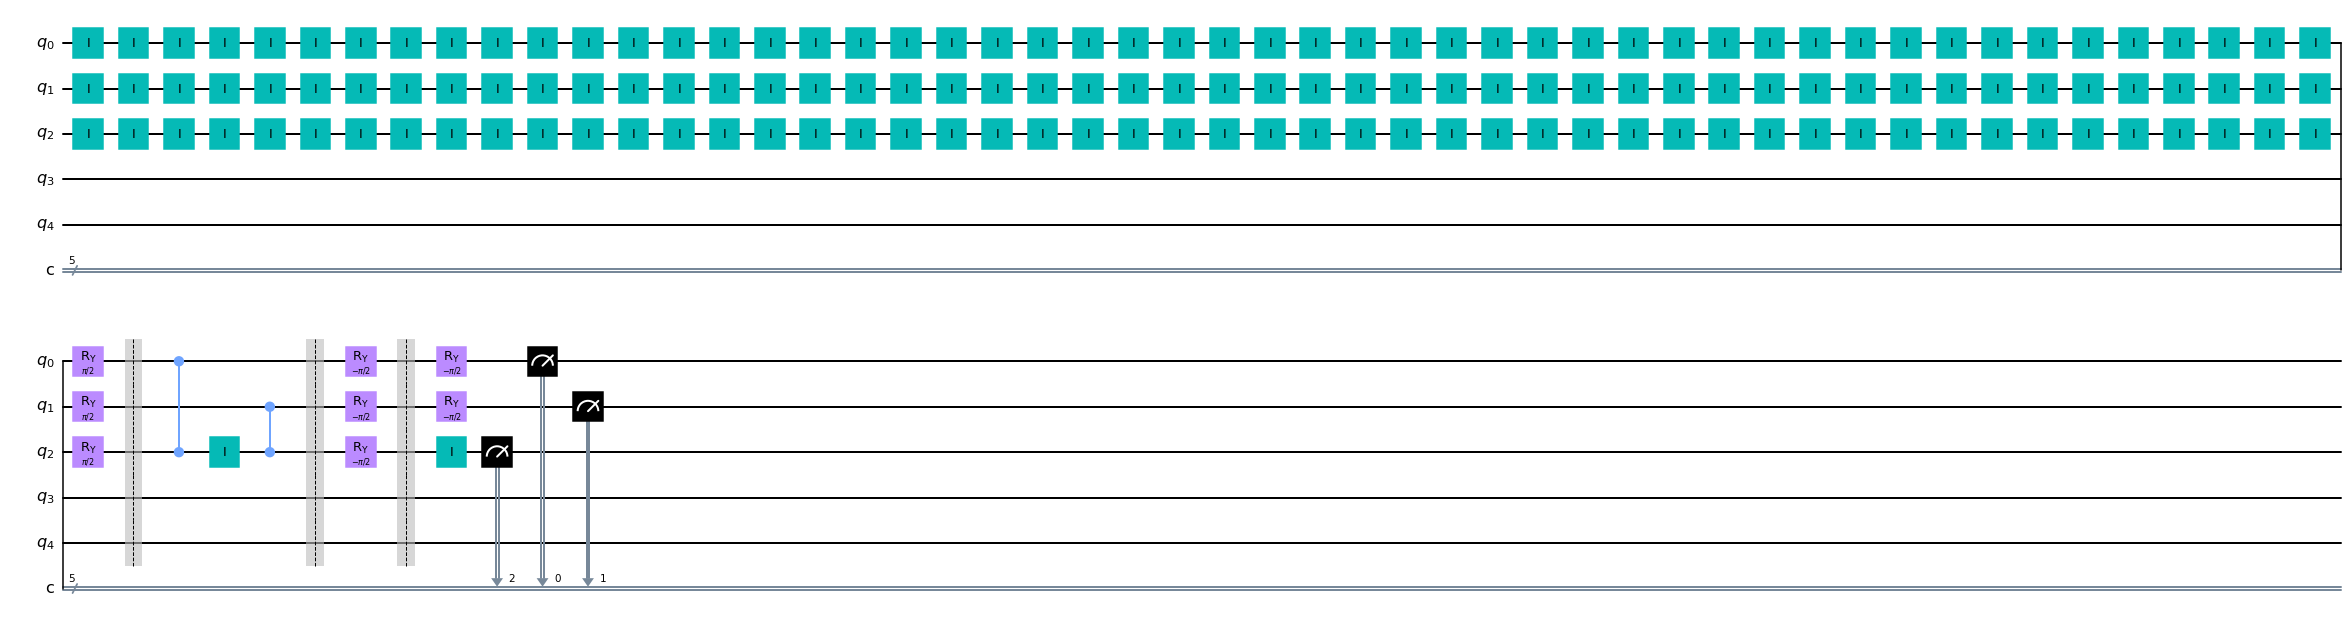

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('X', 'X')
Backend status:  EXECUTION


17:41:10 - inspire_experiments.data_utils:INFO - Saving results for job 7168927 in ./data/


Job with ID 7168927 got status JobStatus.RUNNING


 11%|█         | 1/9 [00:47<06:16, 47.01s/it]

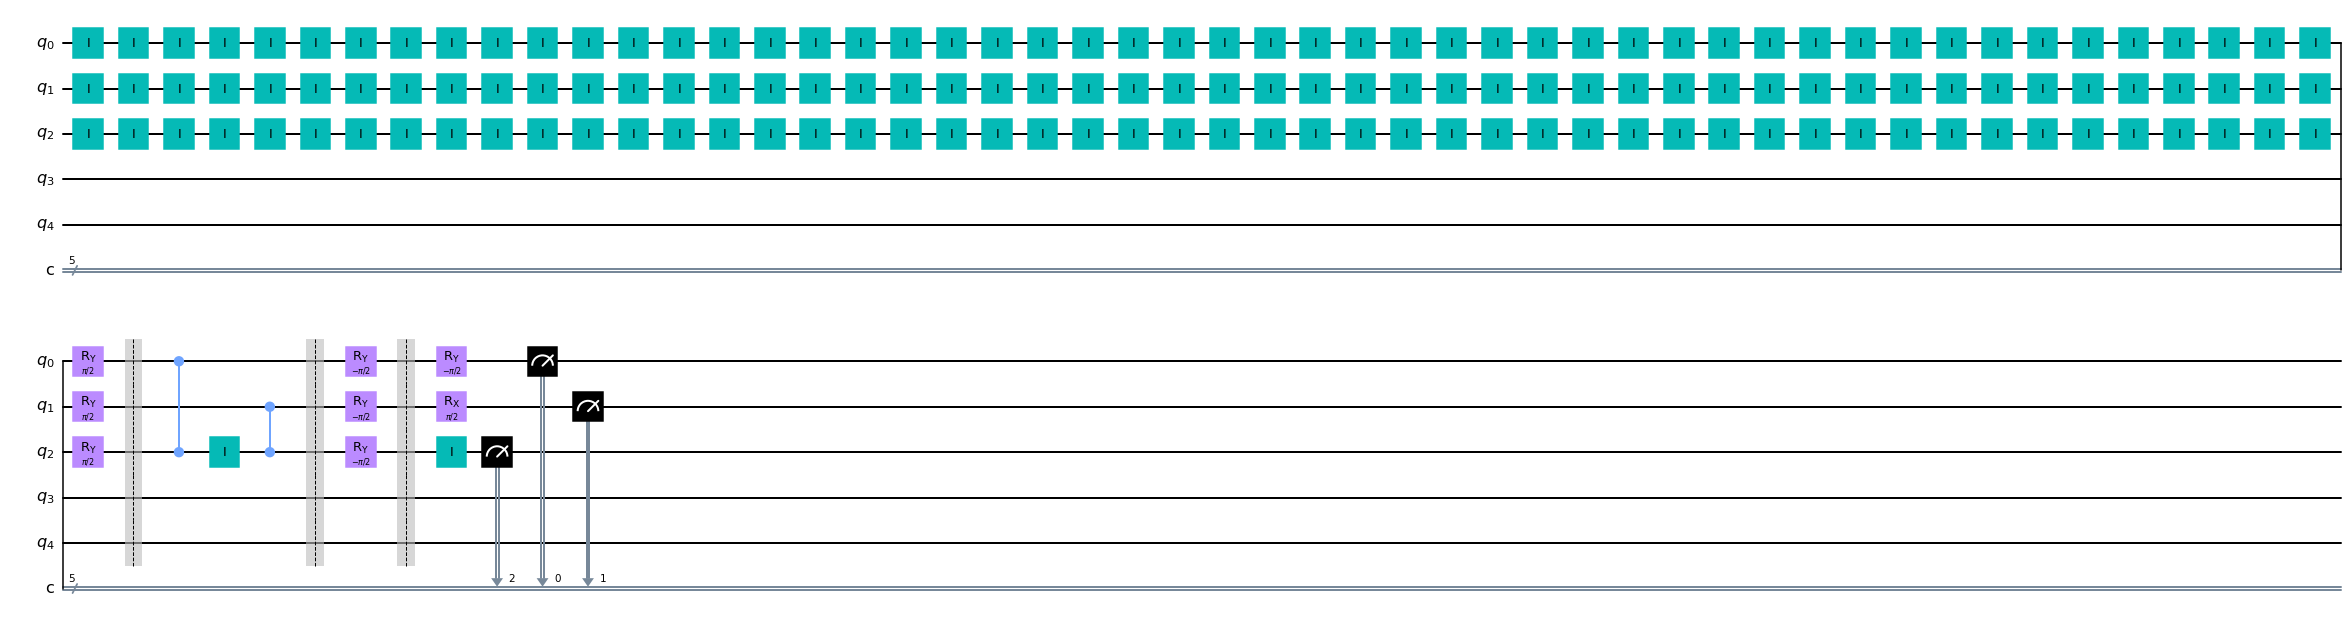

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('X', 'Y')
Backend status:  EXECUTION


17:41:57 - inspire_experiments.data_utils:INFO - Saving results for job 7168928 in ./data/


Job with ID 7168928 got status JobStatus.RUNNING


 22%|██▏       | 2/9 [01:35<05:33, 47.68s/it]

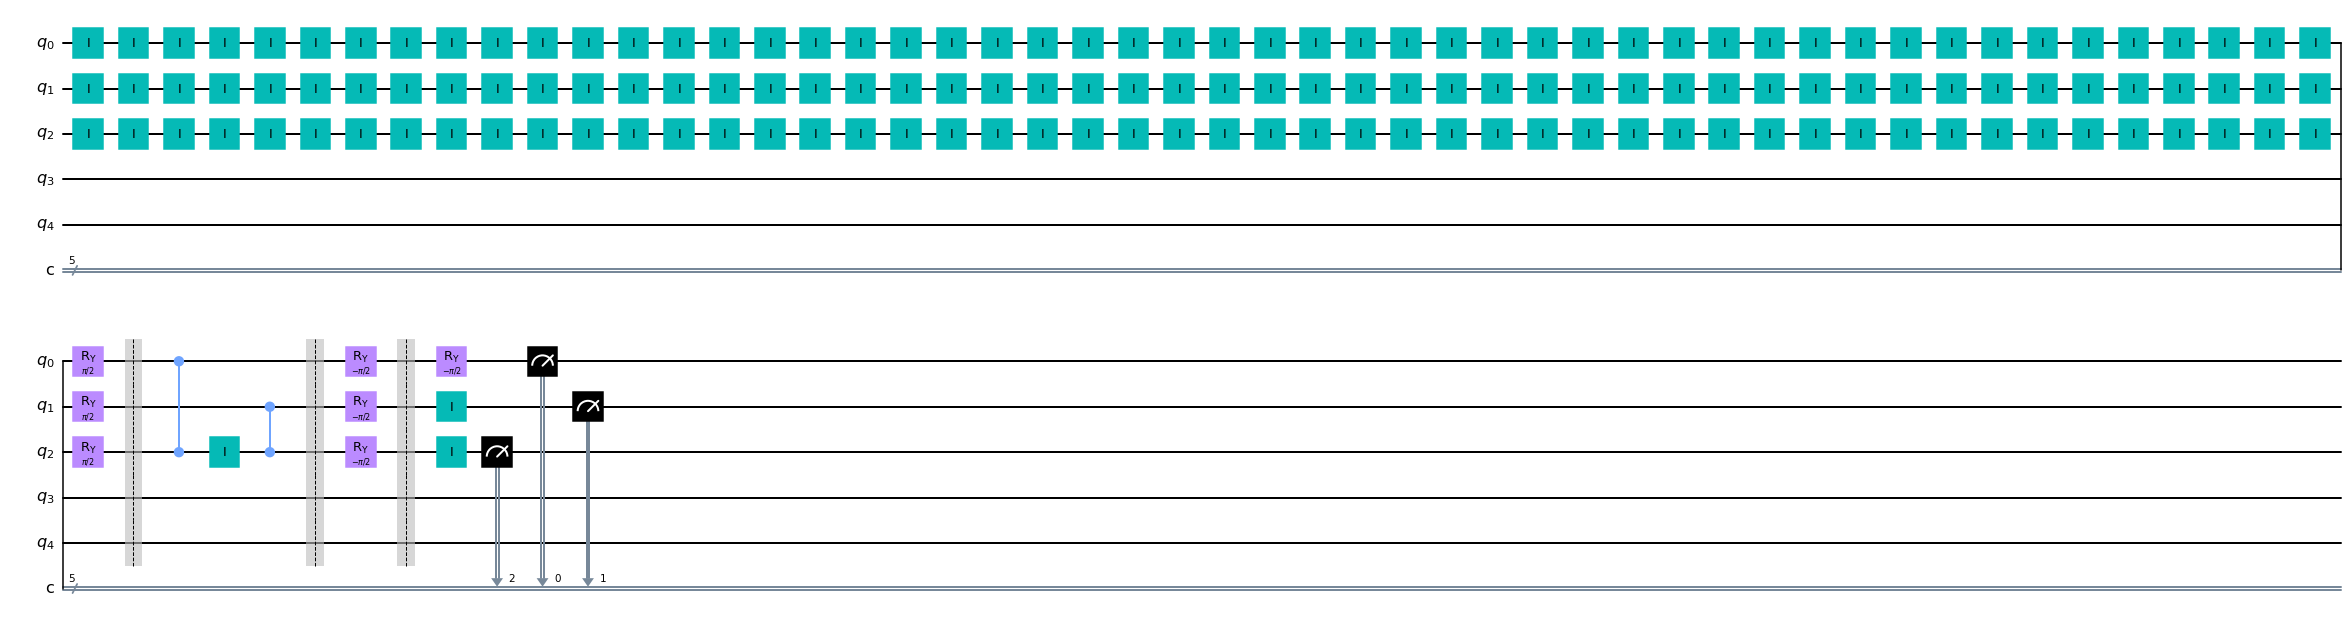

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('X', 'Z')
Backend status:  IDLE


17:42:45 - inspire_experiments.data_utils:INFO - Saving results for job 7168929 in ./data/


Job with ID 7168929 got status JobStatus.RUNNING


 33%|███▎      | 3/9 [02:28<05:01, 50.20s/it]

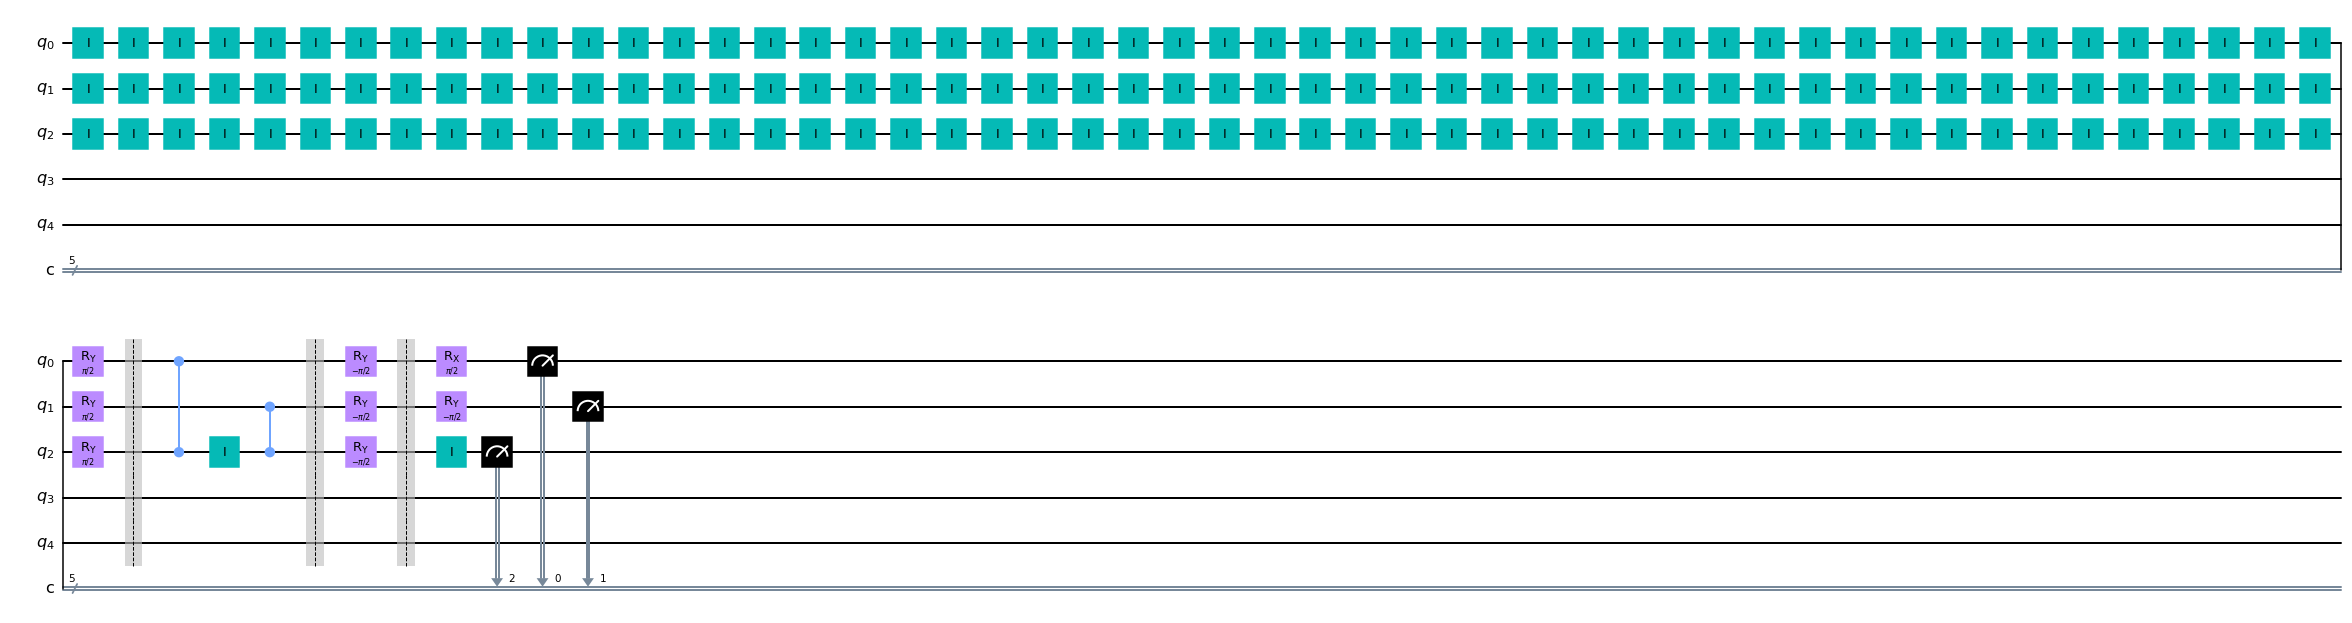

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('Y', 'X')
Backend status:  EXECUTION


17:43:38 - inspire_experiments.data_utils:INFO - Saving results for job 7168930 in ./data/


Job with ID 7168930 got status JobStatus.RUNNING


 44%|████▍     | 4/9 [03:15<04:04, 48.86s/it]

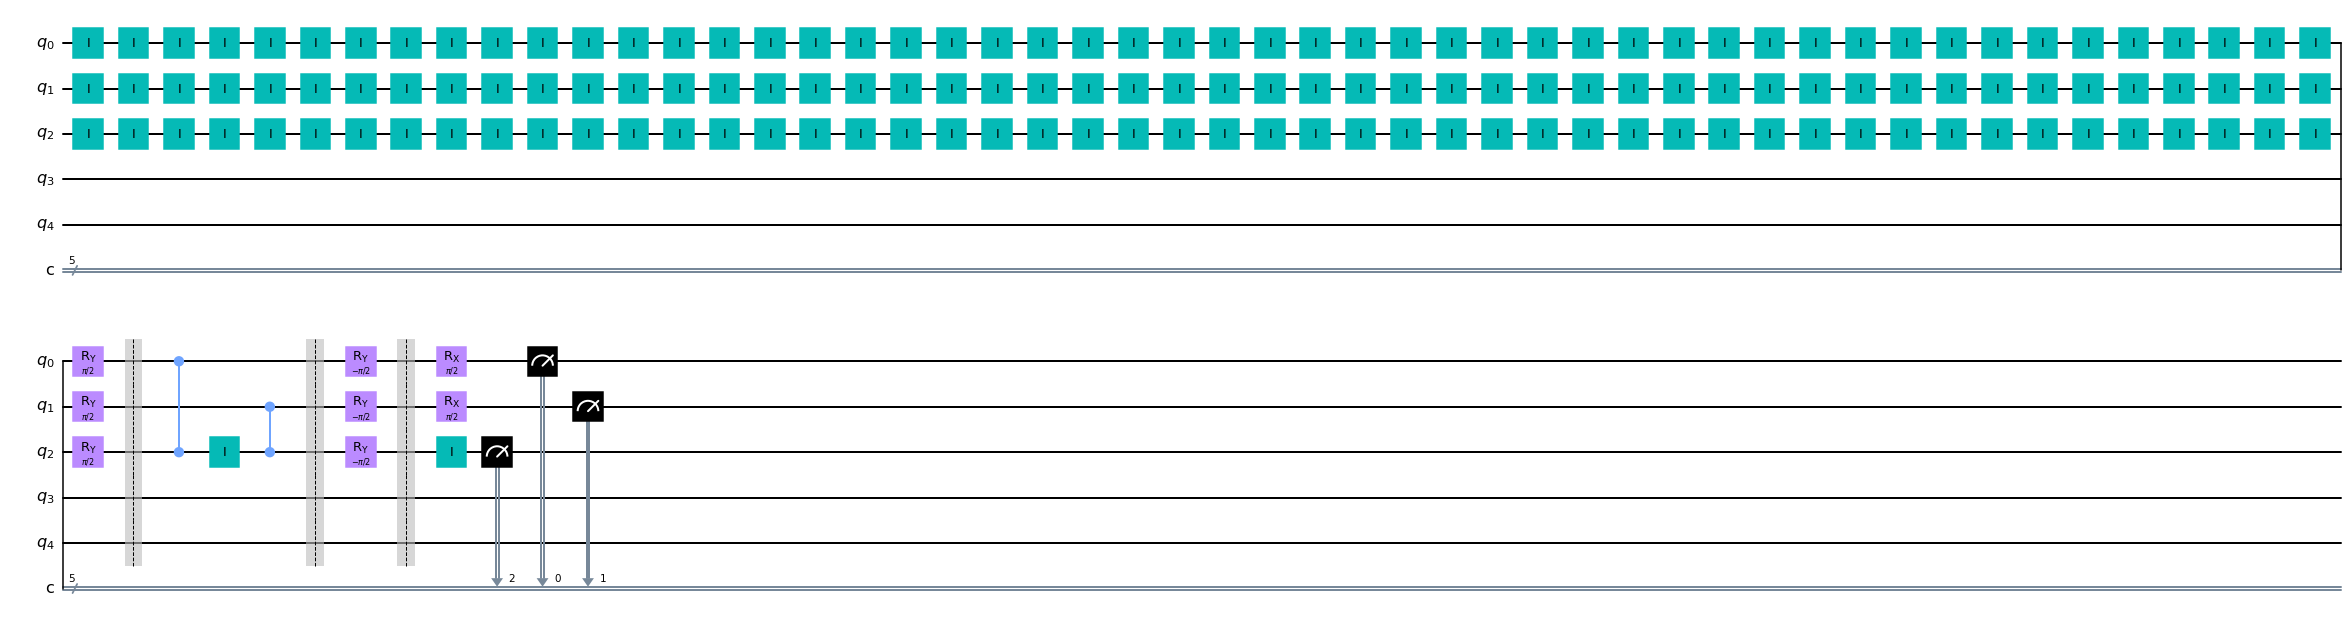

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('Y', 'Y')
Backend status:  EXECUTION


17:44:25 - inspire_experiments.data_utils:INFO - Saving results for job 7168931 in ./data/


Job with ID 7168931 got status JobStatus.RUNNING


 56%|█████▌    | 5/9 [04:02<03:13, 48.26s/it]

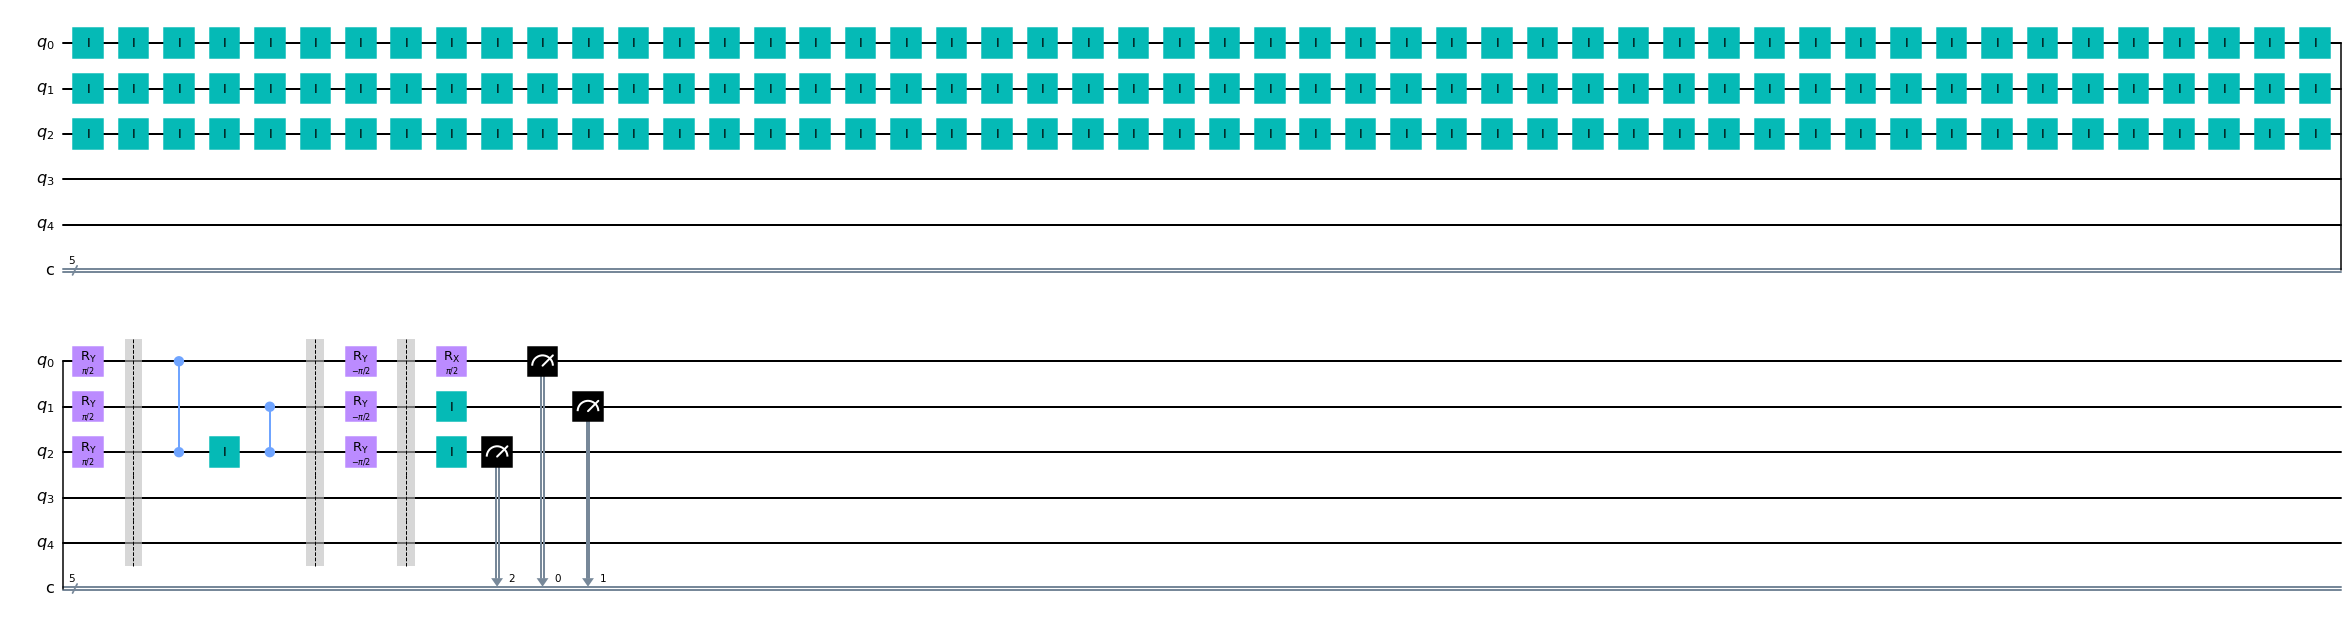

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('Y', 'Z')
Backend status:  EXECUTION


17:45:12 - inspire_experiments.data_utils:INFO - Saving results for job 7168932 in ./data/


Job with ID 7168932 got status JobStatus.RUNNING


 67%|██████▋   | 6/9 [04:48<02:22, 47.63s/it]

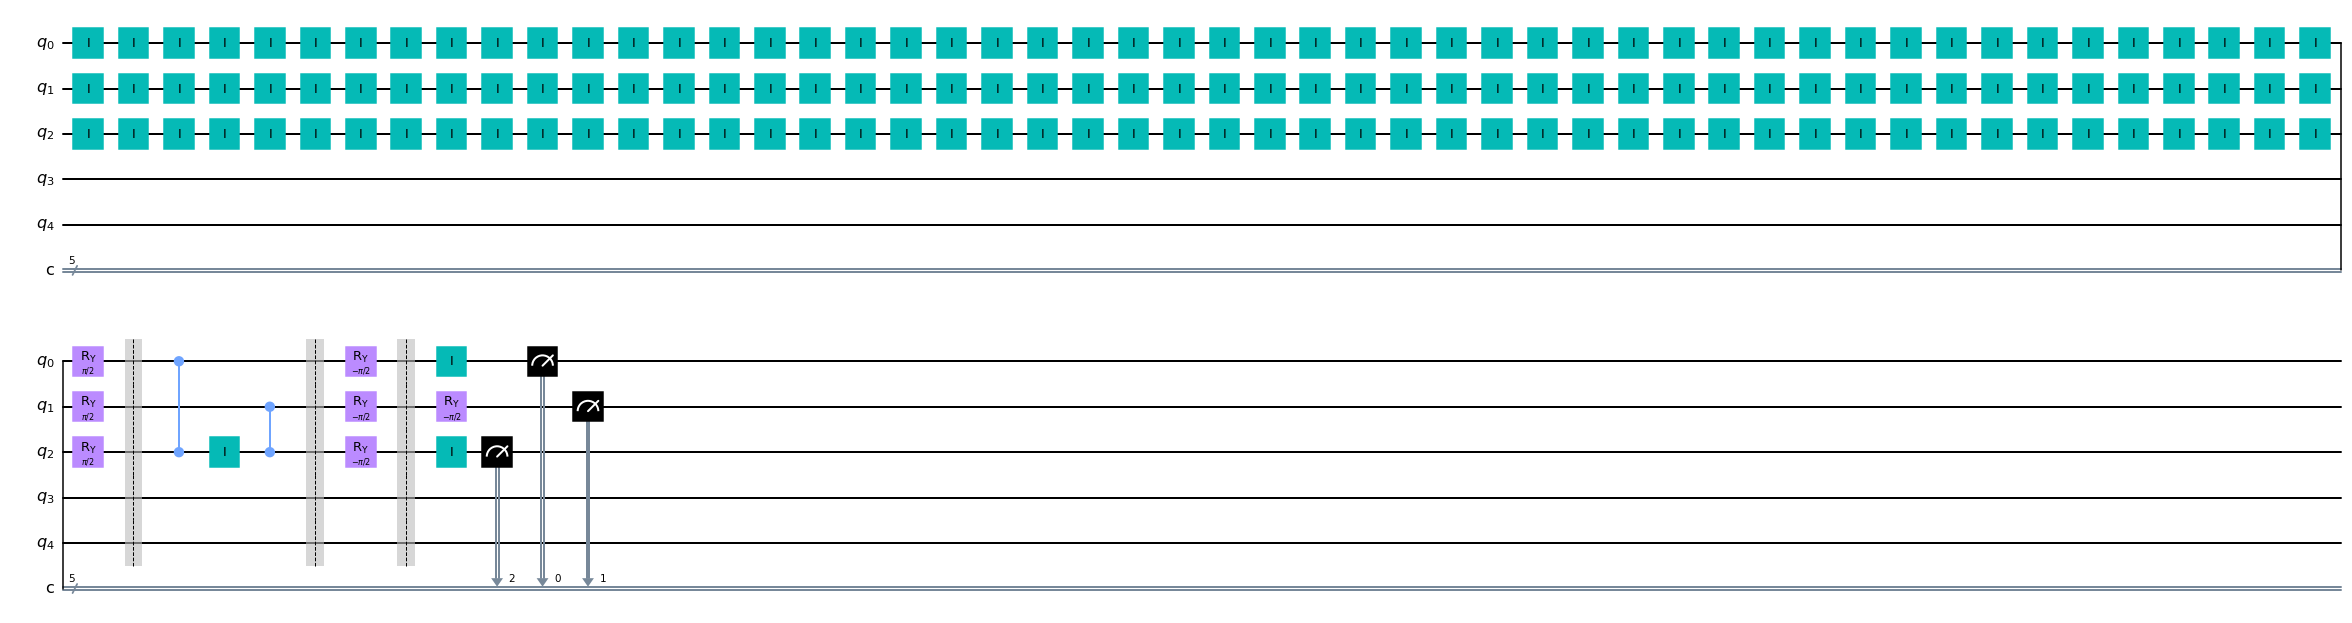

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('Z', 'X')
Backend status:  IDLE


17:45:58 - inspire_experiments.data_utils:INFO - Saving results for job 7168933 in ./data/


Job with ID 7168933 got status JobStatus.QUEUED


 78%|███████▊  | 7/9 [05:36<01:35, 47.74s/it]

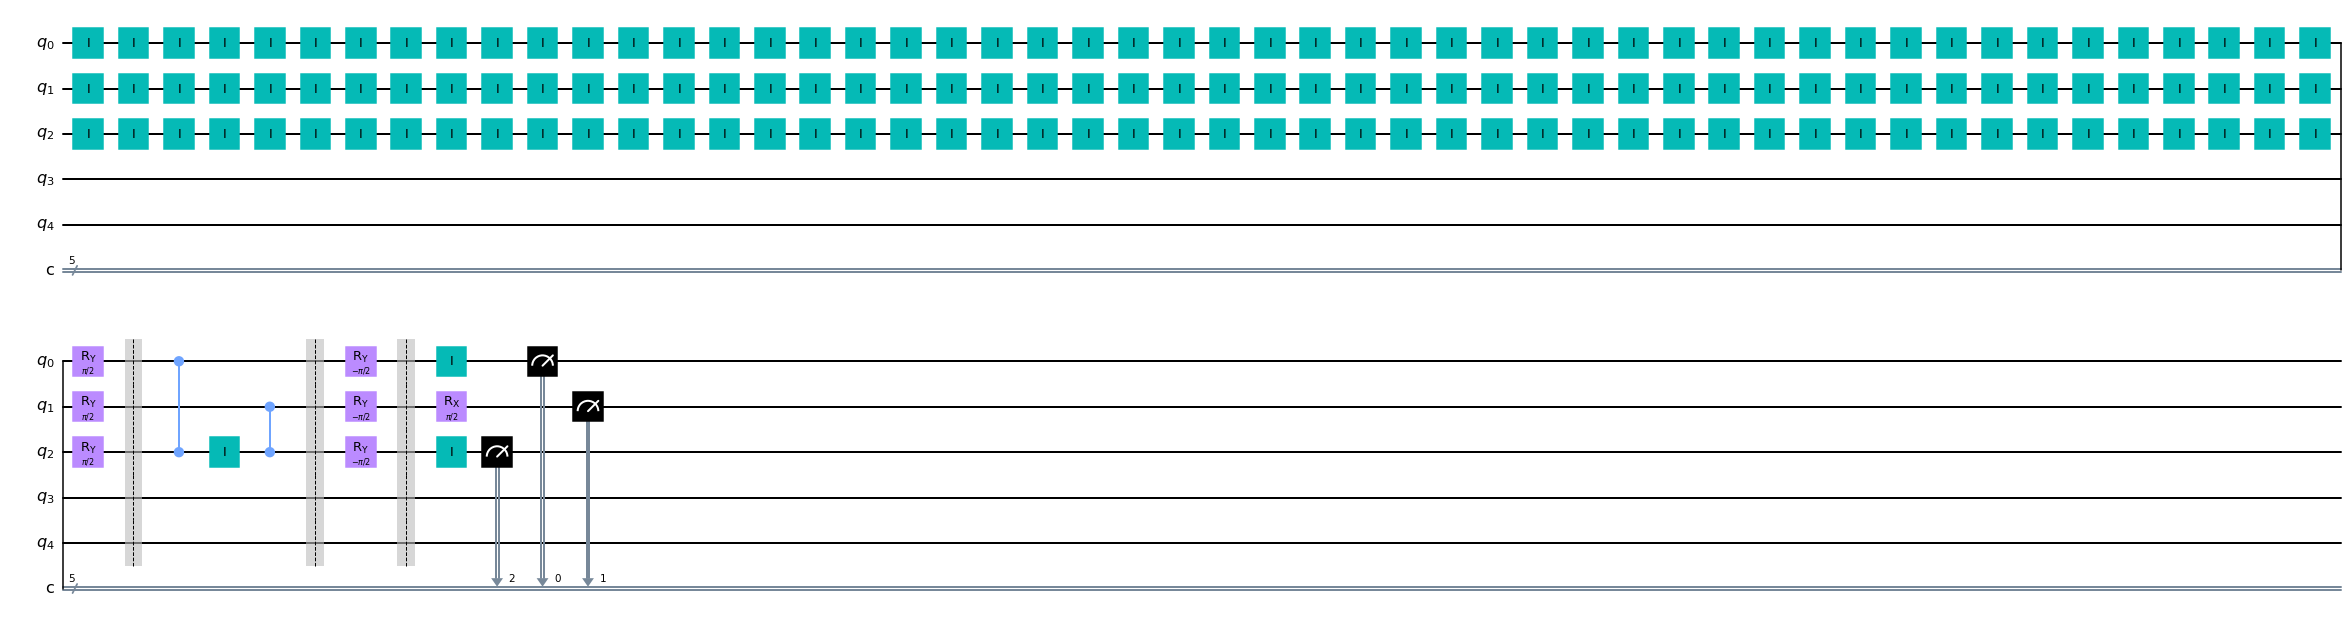

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('Z', 'Y')
Backend status:  IDLE


17:46:46 - inspire_experiments.data_utils:INFO - Saving results for job 7168934 in ./data/


Job with ID 7168934 got status JobStatus.RUNNING


 89%|████████▉ | 8/9 [06:24<00:47, 47.72s/it]

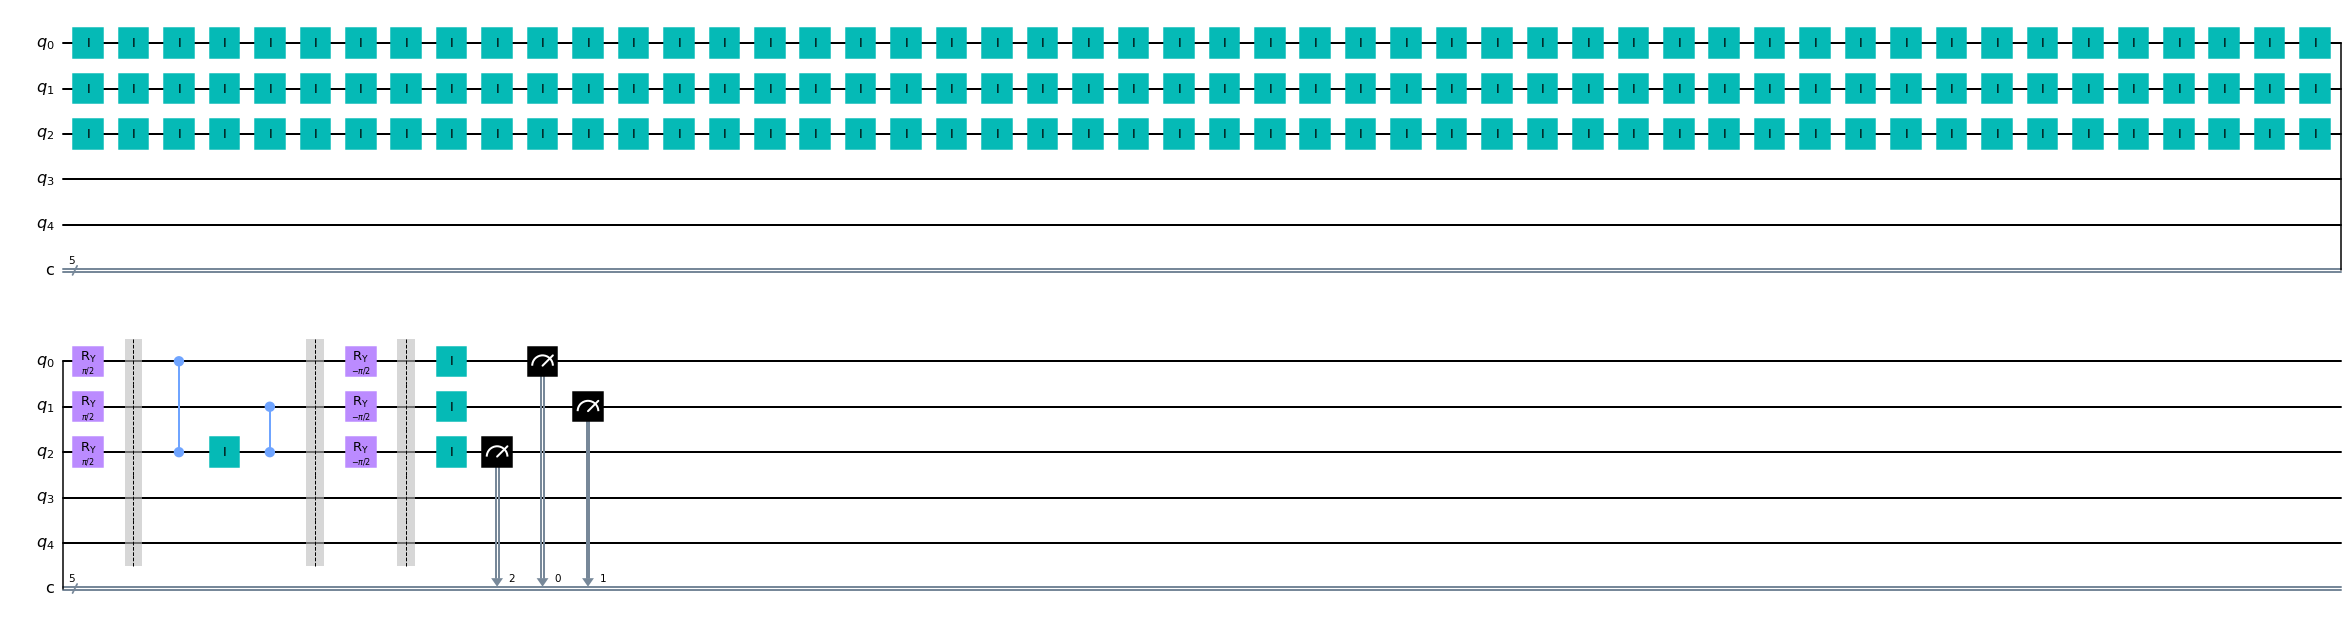

entanglement_by_msmt_qbs[0, 2, 1]_sim-msmt_wait50AfterInit_tom[0, 1]_M('Z', 'Z')
Backend status:  EXECUTION


17:47:34 - inspire_experiments.data_utils:INFO - Saving results for job 7168935 in ./data/


Job with ID 7168935 got status JobStatus.RUNNING


100%|██████████| 9/9 [07:11<00:00, 47.96s/it]


In [29]:
jobs2, circuits2 = measure_entanglement_by_msmt([0,2,1], tomo_qubits=[0,1], extra_label="_wait50AfterInit", send_jobs=True, sim_msmt=True, show_circuit=True)

## readout correction calibration points

In [30]:
measure_readout_correction(qubits=[0,1], extra_label="", backend=backend, send_jobs=True, show_circuit=False)

  0%|          | 0/4 [00:00<?, ?it/s]17:48:18 - inspire_experiments.experiment_library:INFO - readout_correction_qbs[0, 1]_state00
17:48:18 - inspire_experiments.experiment_library:INFO - Backend state: EXECUTION
17:48:18 - inspire_experiments.experiment_library:INFO - Measuring readout correction: state ('0', '0')
17:48:19 - inspire_experiments.data_utils:INFO - Saving results for job 7168936 in ./data/
 25%|██▌       | 1/4 [00:46<02:20, 46.99s/it]17:49:05 - inspire_experiments.experiment_library:INFO - readout_correction_qbs[0, 1]_state01
17:49:05 - inspire_experiments.experiment_library:INFO - Backend state: EXECUTION
17:49:05 - inspire_experiments.experiment_library:INFO - Measuring readout correction: state ('0', '1')
17:49:06 - inspire_experiments.data_utils:INFO - Saving results for job 7168937 in ./data/
 50%|█████     | 2/4 [01:34<01:34, 47.12s/it]17:49:52 - inspire_experiments.experiment_library:INFO - readout_correction_qbs[0, 1]_state10
17:49:52 - inspire_experiments.experi

([<quantuminspire.qiskit.qi_job.QIJob at 0x7fce721d4a90>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7fce69f756c0>])

## Checking/cancelling jobs

In [9]:
[j.status() for j in jobs]

[<JobStatus.RUNNING: 'job is actively running'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>,
 <JobStatus.QUEUED: 'job is queued'>]

In [10]:
for j in jobs:
    try:
        print(j.status())
        j.cancel()
        print(j.status())
    except Exception:
        pass

JobStatus.RUNNING
JobStatus.QUEUED
JobStatus.QUEUED
JobStatus.QUEUED
JobStatus.QUEUED
JobStatus.QUEUED
JobStatus.QUEUED
JobStatus.QUEUED
JobStatus.QUEUED


In [27]:
jobs[0].result().data()['counts_multiple_measurement']


[{'0x0': 2603,
  '0x1': 3587,
  '0x4': 2224,
  '0x5': 2571,
  '0x10': 2397,
  '0x11': 582,
  '0x14': 1936,
  '0x15': 484}]

In [12]:
dir(backend)


['DEFAULT_CONFIGURATION',
 '_QuantumInspireBackend__api',
 '_QuantumInspireBackend__backend',
 '_QuantumInspireBackend__convert_histogram',
 '_QuantumInspireBackend__convert_result_data',
 '_QuantumInspireBackend__convert_result_multiple_shots',
 '_QuantumInspireBackend__convert_result_single_shot',
 '_QuantumInspireBackend__raw_qubit_register_to_raw_data_value',
 '_QuantumInspireBackend__validate_full_state_projection',
 '_QuantumInspireBackend__validate_nr_of_clbits_conditional_gates',
 '_QuantumInspireBackend__validate_number_of_shots',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_configuration',
 '_default_op